In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import gc

os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/2023_06_12_tea_seq_atac_processing/")

path_cite_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/processed_files/"

In [2]:
## Helper functions
def pearson_corr_df_to_df(df1, df2):
    norm1 = df1 - df1.mean(axis=0)
    norm2 = df2 - df2.mean(axis=0)
    sqsum1 = (norm1**2).sum(axis=0)
    sqsum2 = (norm2**2).sum(axis=0)
    return((norm1.T @ norm2) / np.sqrt(sqsum1.apply(lambda x: x*sqsum2)))

In [3]:
new_cluster_order = pd.read_csv("/media/kyle_storage/kyle_ferchen/"\
    "grimes_lab_main/data/2021_11_mouse_optimized_cite_seq/processed_files/"\
    "r7_cluster_order_kf_2024_01.csv")
map_r7_to_lv3 = pd.Series(\
    new_cluster_order["Level 3"].values,
    index=new_cluster_order["Cluster"].values)
map_lvl3_to_order = pd.Series(\
    new_cluster_order["Order"].values,
    index=new_cluster_order["Level 3"].values)
map_r7_to_replace_dash = pd.Series(\
    new_cluster_order["Cluster"].values,
    index=[i.replace("-", "_") for i in new_cluster_order["Cluster"].values])
map_new_cluster_to_order = pd.Series(\
    new_cluster_order["Order"].values,
    index=new_cluster_order["Level 3"].values)

path_cite_data = "/media/kyle_storage/kyle_ferchen/"\
    "grimes_lab_main/data/2021_11_mouse_optimized_cite_seq/processed_files/"
cluster_anno = pd.read_csv(os.path.join(\
    path_cite_data,
    "cluster_anno_r6_r7_lvl4_and_order.csv"))
map_lvl4_to_order = pd.Series(\
    cluster_anno["Order"].values,
    index=cluster_anno["lvl4"].values).dropna().astype(int)
map_lvl4_to_color = pd.Series(\
    cluster_anno["Color"].values,
    index = cluster_anno["lvl4"].values)
map_r7_to_lvl4 = pd.Series(\
    cluster_anno["lvl4"].values,
    index=cluster_anno["R7"].values)
map_lvl4_to_order


qHSC           1
aHSC           2
HSC-Ly         3
MPP5-IER       4
MPP5 Ly-I      5
              ..
ILCP-b        83
ILC2          84
ILC1_3+NKP    85
pre-aceNKP    86
aceNKP        87
Length: 87, dtype: int64

In [4]:
# Seqlet annotation
seqlets = pd.read_feather("output/chrombpnet/modisco_merged_results/fold_0/"\
    "redo_extract_seqlets/all_seqlit_hits_above_modisco_min_anno.fea")

# Seqlets
dp_scores = pd.read_feather("output/chrombpnet/modisco_merged_results/fold_0/"\
    "redo_extract_seqlets/all_seqlit_hits_above_modisco_min_dp_scores.fea")
dp_scores = dp_scores.set_index("index").astype(np.float32)
dp_scores = dp_scores.rename(map_r7_to_replace_dash.to_dict(), axis=1)
dp_scores = dp_scores.rename(map_r7_to_lvl4.to_dict(), axis=1)

In [5]:
# Load CITE-seq data (SoupX 0.15 corrected)
path_to_cite_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/processed_files/"

cite_adata = anndata.read_h5ad(os.path.join(\
    path_to_cite_data,
    "cite_seq_adata_rna_combined_SoupX_0_15_with_R7_clusters.h5ad"))

cite_adata.X = np.log2((10000 * (cite_adata.X.T / \
    cite_adata.X.sum(axis=1).T).T) + 1)

cite_adata.obs["lvl4"] = cite_adata.obs["R7"].replace(\
    map_r7_to_lvl4.to_dict()).values
cite_adata.obs["cluster_order"] = cite_adata.obs["lvl4"].replace(\
    map_lvl4_to_order.to_dict()).values

cite_adata = cite_adata[\
    cite_adata.obs.loc[cite_adata.obs["lvl4"] != "MEP-UNK"].sort_values(\
        by="cluster_order").index.values,
    :]

cite_df = pd.DataFrame(\
    cite_adata.X,
    index=cite_adata.obs.index.values,
    columns=cite_adata.var.index.values)

cite_rna = cite_df.copy()
cite_rna["cluster"] = cite_adata.obs.loc[\
    cite_rna.index.values, "lvl4"].values
cite_rna = pd.pivot_table(cite_rna, index="cluster", aggfunc=np.mean)

In [6]:
### Read in the results from previous analysis of seqlet to gene expression cor
## Gene clusters: hierarchical clusturing across seqlet to gene r values
selected_markers = pd.read_csv(\
    "output/chrombpnet/modisco_merged_results/fold_0/redo_extract_seqlets/WITH_ALL_GENES/"\
    "seqlet_to_gene_expression_correlation_surface_marker_genes.csv")

## Seqlet clusters: MarkerFinder to hierarchical gene clusters
# Read in the seqlet clusters
seqlets_to_marker_genes = pd.read_csv(\
    "output/chrombpnet/modisco_merged_results/fold_0/redo_extract_seqlets/WITH_ALL_GENES/"\
    "seqlet_to_gene_expression_correlation_seqlets_overlapping_surface_marker_genes.csv")

In [7]:
from matplotlib.colors import ListedColormap

def build_listed_cmap(rgb_start, rgb_center, rgb_end):
    # Define a colormap to use for marker expression heatmap
    N = 256
    vals = np.ones((N*2, 4))
    vals[:N, 0] = np.linspace(rgb_start[0]/256, rgb_center[0]/256, N)
    vals[:N, 1] = np.linspace(rgb_start[1]/256, rgb_center[1]/256, N)
    vals[:N, 2] = np.linspace(rgb_start[2]/256, rgb_center[2]/256, N)
    vals[N:, 0] = np.linspace(rgb_center[0]/256, rgb_end[0]/256, N)
    vals[N:, 1] = np.linspace(rgb_center[1]/256, rgb_end[1]/256, N)
    vals[N:, 2] = np.linspace(rgb_center[2]/256, rgb_end[2]/256, N)
    return(ListedColormap(vals))

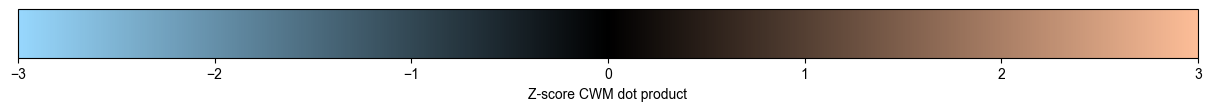

In [8]:
pantone_2023_cmap = build_listed_cmap(\
    rgb_start = (152,216,254),
    rgb_center = (0,0,0),
    rgb_end = (254,190,152))

fig, ax = plt.subplots(figsize=(12, 1), layout='constrained')

cmap = matplotlib.cm.cool
norm = matplotlib.colors.Normalize(vmin=-3, vmax=3)

fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=pantone_2023_cmap),
             cax=ax, orientation='horizontal', label='Z-score CWM dot product')

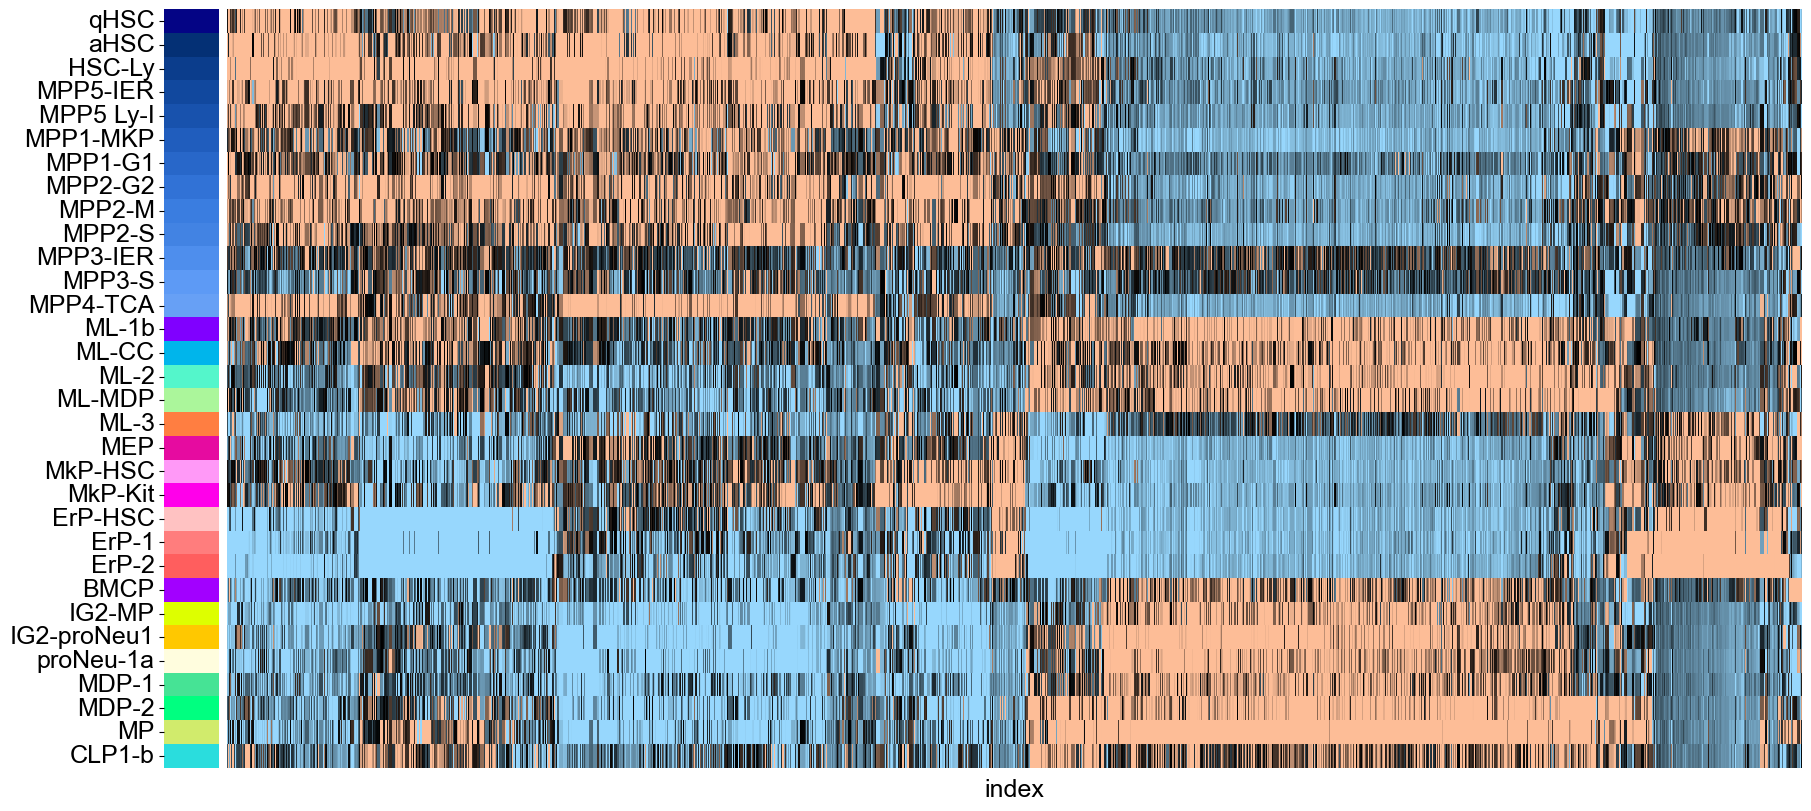

In [9]:
# Make cluster vs seqlet heatmap
ordered_cluster_series = map_lvl4_to_order.loc[\
    dp_scores.columns.values].sort_values()

plt.rcParams.update({'font.size': 18})

# Cluster color bar
# plot_cluster_bars = pd.DataFrame(ordered_cluster_series.loc[\
#     dp_scores.columns.values].sort_values())
plot_cluster_bars = pd.DataFrame(list(range(len(ordered_cluster_series))),
    index=ordered_cluster_series.index.values)

fig = plt.figure(constrained_layout=True, figsize=(18,8))
ax = fig.add_gridspec(1, 150)
ax1 = fig.add_subplot(ax[0, :5])
ax2 = fig.add_subplot(ax[0, 5:])
heat1 = sns.heatmap(plot_cluster_bars.astype(np.float32),
                        cmap=matplotlib.colors.ListedColormap(\
                            (map_lvl4_to_color.loc[\
                                plot_cluster_bars.index.values]).values),
                        yticklabels=True,
                        xticklabels=False,
                        cbar=False,
                        ax=ax1)

heat2 = sns.heatmap(\
    zscore(dp_scores.loc[\
        seqlets_to_marker_genes["seqlet_idx"].values, 
        ordered_cluster_series.loc[\
            dp_scores.columns.values].sort_values().index.values],
        axis=1).T, 
    vmin=-1, 
    vmax=1, 
    cmap=pantone_2023_cmap,
    xticklabels=False,
    yticklabels=False,
    cbar=False,
    rasterized=True,
    ax=ax2)

plt.savefig("output/main_figure_outputs/all_genes_update/"\
    "seqlet_heatmap_ordered_by_gene_exp_to_seqlet_correlation_values_surface_markers_lvl4.pdf",
    dpi=300)

In [10]:
path_fig1_heatmap_stuff = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/"\
    "analysis/2023_06_14_nominate_regions_for_mpra_assay/output/plots_for_pub/"

rna_data_to_plot = pd.read_csv(os.path.join(\
        path_fig1_heatmap_stuff, 
        "rna_markers_heatmap.csv"), 
    index_col=0)
cell_assignments = pd.read_csv(os.path.join(\
        path_fig1_heatmap_stuff, 
        "cell_assigments_annotation.csv"), 
    index_col=0)
cell_assignments_reorder = cell_assignments.loc[rna_data_to_plot.columns.values]

cell_assignments_reorder["cluster"] = cell_assignments_reorder[\
    "original"].replace(map_r7_to_lvl4.to_dict()).values
cell_assignments_reorder["cluster_order"] = cell_assignments_reorder[\
    "cluster"].replace(map_lvl4_to_order.to_dict()).values
cell_assignments_reorder = cell_assignments_reorder.sort_values(\
    by=["cluster_order", "top_corr"], ascending=[True, False])

cell_assignments_reorder

,top_cluster,top_corr,original,port,port_group,cluster,cluster_order
cell,,,,,,,
TCGGATAGTGTCACAT-1.AS_CITE_HSC,LT-HSC_Mllt3,0.929229,LT-HSC_Mllt3,AS_CITE_HSC,HSCP,qHSC,1
TTCGATTTCCTTATGT-1.AS_CITE_HSC,LT-HSC_Mllt3,0.929224,LT-HSC_Mllt3,AS_CITE_HSC,HSCP,qHSC,1
TTTGTTGCAGCAGTGA-1.AS_CITE_HSC,LT-HSC_Mllt3,0.928954,LT-HSC_Mllt3,AS_CITE_HSC,HSCP,qHSC,1
TGAGTCAGTGCTATTG-1.AS_CITE_HSC,LT-HSC_Mllt3,0.926503,LT-HSC_Mllt3,AS_CITE_HSC,HSCP,qHSC,1
CCTCTAGTCATAAGGA-1.AS_CITE_HSC,LT-HSC_Mllt3,0.925063,LT-HSC_Mllt3,AS_CITE_HSC,HSCP,qHSC,1
...,...,...,...,...,...,...,...
AGTAACCTCACCTCAC-1.AS_CITE_Multilin2,MEP-UNK,0.553438,MEP-UNK,AS_CITE_Multilin2,MultiLin,MEP-UNK,MEP-UNK
CACTGAAAGCCTGAGA-1.AS_3CITE_Kitx2,MEP-UNK,0.552790,MEP-UNK,AS_3CITE_Kitx2,CD117,MEP-UNK,MEP-UNK
CTCAATTAGGACTAAT-1.AS_CITE_HSC,MEP-UNK,0.552115,MEP-UNK,AS_CITE_HSC,HSCP,MEP-UNK,MEP-UNK


In [11]:
selected_markers

,gene,cluster
0,Alcam,1
1,Entpd1,2
2,Il15,2
3,Cd1d1,3
4,Mfge8,5
...,...,...
254,Ccr1,169
255,Fcer1a,169
256,Cdh1,169
257,Cd200r3,169


/tmp/ipykernel_143203/2036197100.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_tick_positions["pos"] = list(range(1, 1+cell_tick_positions.shape[0]))


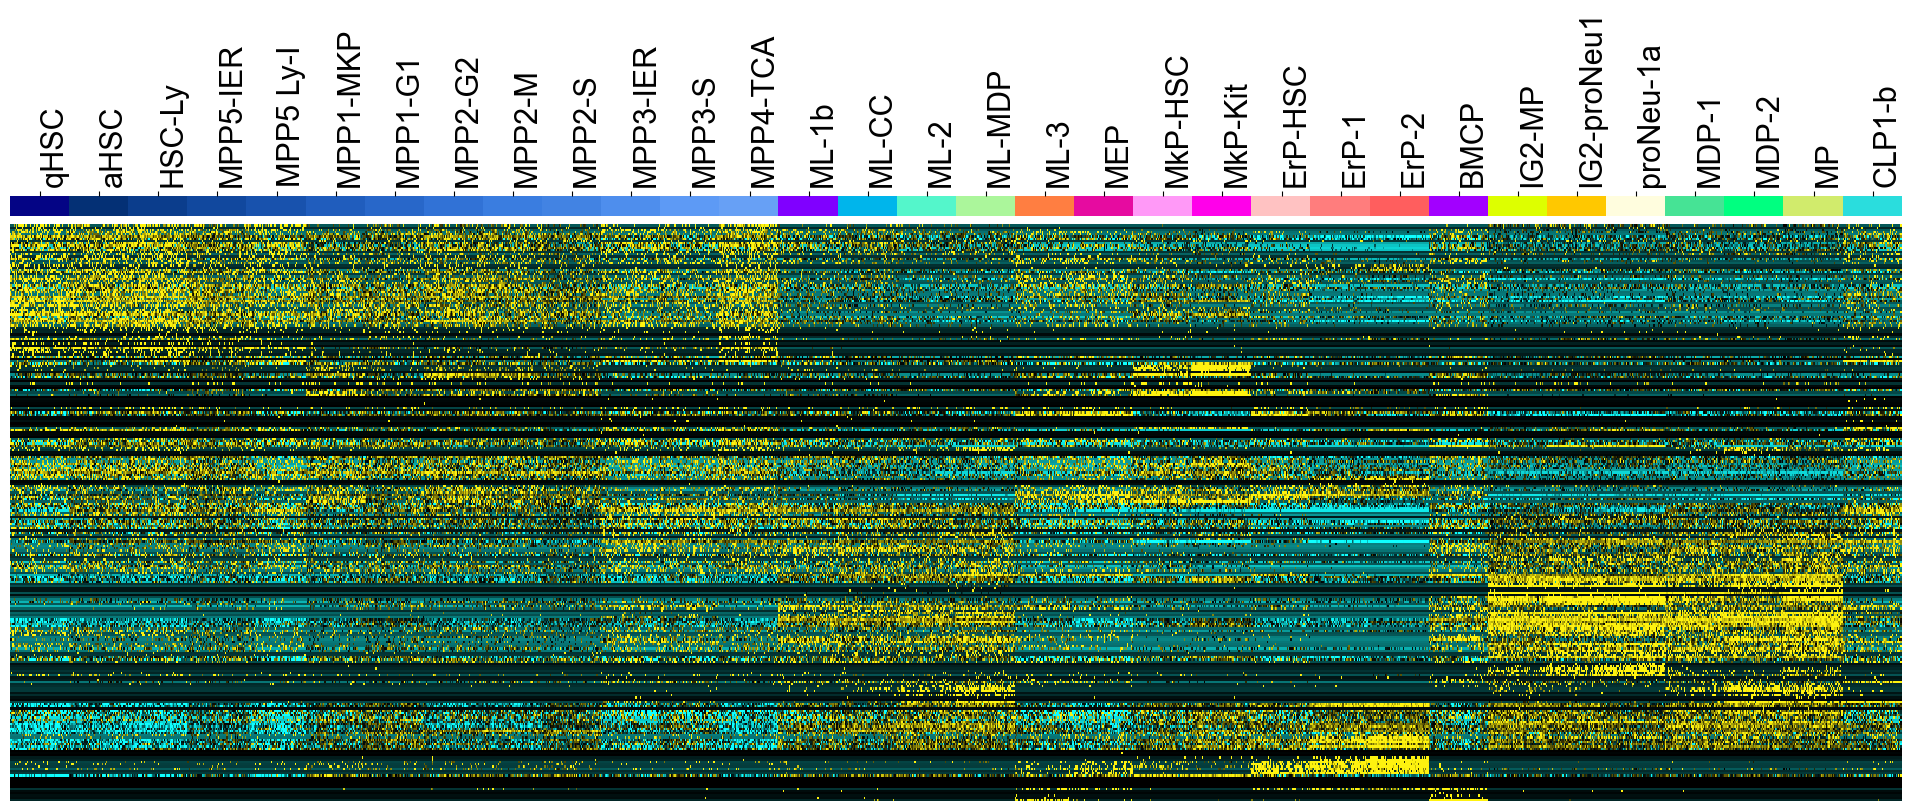

In [13]:
# Plot RNA expression heatmap
from pyInfinityFlow.Plotting_Utilities import blue_black_yellow_cmap

plt.rcParams.update({'font.size': 22})

# Prepare the ordered cells to use (borrow from figure 1 heatmap)
filtered_cells = cell_assignments_reorder.loc[\
    cell_assignments_reorder["cluster"].isin(dp_scores.columns.values)]

# Prepare cluster label positions
cell_tick_positions = filtered_cells[["cluster"]]
cell_tick_positions["pos"] = list(range(1, 1+cell_tick_positions.shape[0]))
cell_tick_positions = pd.pivot_table(\
    cell_tick_positions,
    index = "cluster",
    values = "pos",
    aggfunc = np.mean).sort_values(by="pos")

# RNA data to plot
rna_data_to_plot = zscore(cite_df.loc[\
    filtered_cells.index.values, 
    selected_markers["gene"].values].T, axis=1)

# Cluster color bar
plot_cluster_bars = filtered_cells[["cluster"]].T.copy()
unique_clusters = plot_cluster_bars.loc["cluster"].unique()
map_cluster_to_order = pd.Series(\
    list(range(len(unique_clusters))), 
    index=unique_clusters).to_dict()
plot_cluster_bars.loc["cluster",:] = plot_cluster_bars.loc["cluster"].replace(\
    map_cluster_to_order)
plot_cluster_bars.columns.name = None


# tmp_color_series = pd.Series('#000000', index=map_lvl4_to_color.index.values)
tmp_clusters = filtered_cells["cluster"].unique()
tmp_color_series = map_lvl4_to_color.loc[tmp_clusters].copy()


# Construct figure
fig = plt.figure(constrained_layout=True, figsize=(19,8))
ax = fig.add_gridspec(150, 1)
ax1 = fig.add_subplot(ax[:5, 0])
ax2 = fig.add_subplot(ax[5:, 0])
heat1 = sns.heatmap(plot_cluster_bars.astype(np.float32),
                        cmap=matplotlib.colors.ListedColormap(\
                            tmp_color_series.values),
                        yticklabels=False,
                        xticklabels=False,
                        cbar=False,
                        ax=ax1)

ax1.set_xticks(\
    ticks = cell_tick_positions["pos"].values,
    labels = cell_tick_positions.index.values, 
    ha="left")
ax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False,
    labelrotation=90)

heat2 = sns.heatmap(rna_data_to_plot.fillna(0), 
                        vmin=-1.5, 
                        vmax=1.5, 
                        cmap=blue_black_yellow_cmap,
                        xticklabels=False,
                        yticklabels=False,
                        cbar=False,
                        rasterized=True,
                        ax=ax2)

ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=12)


plt.savefig("output/main_figure_outputs/all_genes_update/"\
    "gene_expression_heatmap_ordered_by_gene_exp_to_seqlet_correlation_values_surface_markers_lvl4.pdf",
    dpi=300)

In [17]:
seqlets_to_marker_genes.shape

(8001, 4)